this code is about the classification of the chest CT images into one of the four cancerous conditions namely adenocarcinoma, large cell carcinoma, squamous cell carcinoma and normal.

In [ ]:
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image

the dataset consists of about 1000 different lung CT images.

In [ ]:
!unzip '/content/Project 1 DWI.zip'

Archive:  /content/Project 1 DWI.zip
replace test/Cancer DWI Only Photos/download (32).png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: test/Cancer DWI Only Photos/download (32).png  
  inflating: test/Cancer DWI Only Photos/download (35).png  
  inflating: test/Cancer DWI Only Photos/download (37).png  
  inflating: test/DWI Normal Only photos/download (10).png  
  inflating: test/DWI Normal Only photos/download (11).png  
  inflating: test/DWI Normal Only photos/download (12).png  
  inflating: train/Cancer DWI Only Photos/download (1).png  
  inflating: train/Cancer DWI Only Photos/download (10).png  
  inflating: train/Cancer DWI Only Photos/download (11).png  
  inflating: train/Cancer DWI Only Photos/download (12).png  
  inflating: train/Cancer DWI Only Photos/download (13).png  
  inflating: train/Cancer DWI Only Photos/download (14).png  
  inflating: train/Cancer DWI Only Photos/download (16).png  
  inflating: train/Cancer DWI Only Photos/download (17).png  
  infla

I have used imagedatagenerator to generate samples from the given image datasets by applying the specified transforms.

In [ ]:
train_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1)
val_datagen= image.ImageDataGenerator( 
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1)
test_datagen= image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    '/content/train',
    target_size = (224,224),
    batch_size = 8,
    class_mode = 'categorical')
test_generator = test_datagen.flow_from_directory(
    '/content/valid',
    target_size = (224,224),
    batch_size = 8,
    shuffle=True,
    class_mode = 'categorical')
validation_generator = test_datagen.flow_from_directory(
    '/content/test',
    target_size = (224,224),
    batch_size = 8,
    shuffle=True,
    class_mode = 'categorical')

Found 44 images belonging to 2 classes.
Found 6 images belonging to 2 classes.
Found 6 images belonging to 2 classes.


I have developed a transfer learning based EfficientNetB3 model that has been trained on imagenet dataset. I have added some additional layers to the basic model.

In [ ]:
base_model = tf.keras.applications.EfficientNetB3(weights='imagenet', input_shape=(224,224,3), include_top=False)

for layer in base_model.layers:
    layer.trainable=True
model = Sequential()
model.add(base_model)
model.add(GaussianNoise(0.25))
model.add(GlobalAveragePooling2D())
model.add(Dense(1024,activation='relu'))
model.add(BatchNormalization())
model.add(GaussianNoise(0.25))
model.add(Dropout(0.25))
model.add(Dense(2, activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 7, 7, 1536)       10783535  
                                                                 
 gaussian_noise_10 (Gaussian  (None, 7, 7, 1536)       0         
 Noise)                                                          
                                                                 
 global_average_pooling2d_5   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 1024)              1573888   
                                                                 
 batch_normalization_5 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                      

The model has been compiled using cross entropy loss function, adam optimiser and the following metrics:

accuracy

AUC

precision

recall

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              metrics=['accuracy','AUC','Precision','Recall'])

In [ ]:
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# es=EarlyStopping(patience=3,monitor='val_loss')
# filepath='best_model.h5'
# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# history = model.fit(
#     train_generator,
#     epochs=30,
#     validation_data=validation_generator,
#     steps_per_epoch= 75,
#     callbacks=checkpoint
#     )


from keras.callbacks import ModelCheckpoint, EarlyStopping
es=EarlyStopping(monitor='val_loss',patience=3)
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator
    )

Epoch 1/30
6/6 [==============================] - 1s 214ms/step - loss: 1.0199 - accuracy: 0.5455 - auc: 0.5449 - precision: 0.5600 - recall: 0.6364 - val_loss: 0.7449 - val_accuracy: 0.5000 - val_auc: 0.5278 - val_precision: 1.0000 - val_recall: 0.5000
Epoch 2/30
6/6 [==============================] - 1s 191ms/step - loss: 0.9457 - accuracy: 0.5455 - auc: 0.5684 - precision: 0.5814 - recall: 0.5682 - val_loss: 0.7959 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000
Epoch 3/30
6/6 [==============================] - 1s 197ms/step - loss: 0.6624 - accuracy: 0.6818 - auc: 0.6601 - precision: 0.5682 - recall: 0.5682 - val_loss: 0.8356 - val_accuracy: 0.3333 - val_auc: 0.4444 - val_precision: 0.4286 - val_recall: 0.5000
Epoch 4/30
6/6 [==============================] - 1s 202ms/step - loss: 0.5608 - accuracy: 0.6818 - auc: 0.7193 - precision: 0.6383 - recall: 0.6818 - val_loss: 0.6443 - val_accuracy: 0.5000 - val_auc: 0.6111 - val_precision: 0.7500 - val

the model has produced the following results:

training accuracy= 92.17%

training loss= 0.2283

training precision= 58%

training recall= 98.21%

training AUC= 0.9784

In [ ]:
model.evaluate(train_generator)

6/6 [==============================] - 1s 98ms/step - loss: 0.5234 - accuracy: 0.7727 - auc: 0.7505 - precision: 0.6667 - recall: 0.5455


[0.5233778357505798,
 0.7727272510528564,
 0.7505165338516235,
 0.6666666865348816,
 0.5454545617103577]

the model has produced the following results:

validation accuracy= 73.65%

validation loss= 0.6912

validation precision= 46.58%

validation recall= 93.02%

validation AUC= 0.9019

In [ ]:
model.evaluate(validation_generator)

1/1 [==============================] - 0s 139ms/step - loss: 0.4320 - accuracy: 0.8333 - auc: 0.8333 - precision: 0.7500 - recall: 0.5000


[0.4320213794708252, 0.8333333134651184, 0.8333333134651184, 0.75, 0.5]

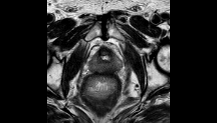

In [ ]:
imag = tf.keras.utils.load_img('/content/valid/Cancer DWI Only Photos/download (15).png')
imag

In [ ]:
from PIL import Image
img=Image.open("/content/valid/Cancer DWI Only Photos/download (15).png")
w,h=img.size    # w=Width and h=Height
print("Width =",w,end="\t")
print("Height =",h)
imag = imag.resize((224, 224))
from PIL import Image
w,h=imag.size    # w=Width and h=Height
print("Width =",w,end="\t")
print("Height =",h)


Width = 217	Height = 123
Width = 224	Height = 224


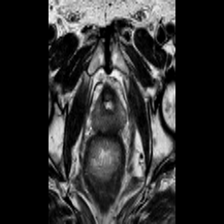

In [ ]:
imag

1/1 [==============================] - 3s 3s/step
[[0.58440906 0.17500319]]
THE UPLOADED IMAGE IS SUSPECTED AS: Cancer


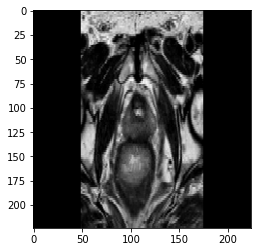

In [ ]:
from tensorflow.keras.utils import load_img
from keras.preprocessing import image
img = tf.keras.utils.load_img('/content/valid/Cancer DWI Only Photos/download (15).png',target_size=(224,224))
# imag = tf.keras.utils.load_img('/content/valid/Cancer DWI Only Photos/download (15).png')
imaga = np.expand_dims(imag,axis=0) 
ypred = model.predict(imaga)
print(ypred)
a=np.argmax(ypred,-1)
if a==0:
  op="Cancer"
elif a==1:
  op="Normal"   
plt.imshow(img)
print("THE UPLOADED IMAGE IS SUSPECTED AS: "+str(op))  


In [ ]:
tf.keras.models.save_model(model,'mymodel.vahid')

In [ ]:
!pip install streamlit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.0/79.0 KB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 72.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 KB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 KB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 KB 7.4 MB/s eta 0:00:00
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19581 sha256=a909d720b6b130fb988b98847512ff8fc152950fc9791aeb6ec2f432145f5899
  Stored in directory: /root/.cache/pip/wheels/19/09/72/3eb

I have developed a website using streamlit that accepts the lung CT image from the user in the format of PNG, JPG or JPEG. Once uploaded, the model will classify the input image into one of the four cancerous conditions (adenocarcinoma, large cell carcinoma, squamous cell carcinoma.

In [ ]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import streamlit as st
from tensorflow.keras.preprocessing import image
from PIL import Image, ImageOps
import pandas as pd
import cv2
import numpy as np


html_temp = """ 
  <div style="background-color:pink ;padding:10px">
  <h2 style="color:white;text-align:center;"> LUNG CT IMAGE CLASSIFICATION ⚕️⚕️⚕️</h2>
  </div>
  """ 
st.markdown(html_temp, unsafe_allow_html=True) 
html_temp = """ 
  <div style="background-color:teal ;padding:10px">
  <h2 style="color:white;text-align:center;"> Done by Sairam Adithya</h2>
  </div>
  """ 
st.markdown(html_temp, unsafe_allow_html=True) 
st.header('Types of cancer covered in the dataset are:')
st.subheader('1. Adenocarcinoma')
st.write('Cancer is a medical condition which is due to abnormal, uncontrollable, uncoordinated division of cells.')
st.write('Adenocarcinoma of the lung: Lung adenocarcinoma is the most common form of lung cancer accounting for 30 percent of all cases overall and about 40 percent of all non-small cell lung cancer occurrences. Adenocarcinomas are found in several common cancers, including breast, prostate and colorectal. Adenocarcinomas of the lung are found in the outer region of the lung in glands that secrete mucus and help us breathe. Symptoms include coughing, hoarseness, weight loss and weakness.')
st.subheader('2. Large cell carcinoma')
st.write('Large-cell undifferentiated carcinoma: Large-cell undifferentiated carcinoma lung cancer grows and spreads quickly and can be found anywhere in the lung. This type of lung cancer usually accounts for 10 to 15 percent of all cases of NSCLC. Large-cell undifferentiated carcinoma tends to grow and spread quickly.')
st.subheader('3. Squamous cell carcinoma')
st.write('Squamous cell: This type of lung cancer is found centrally in the lung, where the larger bronchi join the trachea to the lung, or in one of the main airway branches. Squamous cell lung cancer is responsible for about 30 percent of all non-small cell lung cancers, and is generally linked to smoking.')
st.subheader('4. Normal')
st.write('This is normal lung CT image.')
@st.cache(allow_output_mutation=True)
def load_model():
   model=tf.keras.models.load_model('/content/mymodel.hdf5')
   return model
with st.spinner('Model is being loaded..'):
    model=load_model()
file = st.file_uploader("Please upload any image from the local machine in case of computer or upload camera image in case of mobile.", type=["jpg", "png","jpeg"])
st.set_option('deprecation.showfileUploaderEncoding', False)
def import_and_predict(image_data, model):   
        size = (224,224)    
        image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
        image = np.asarray(image)
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #img_resize = (cv2.resize(img, dsize=(75, 75),    interpolation=cv2.INTER_CUBIC))/255.
        
        img_reshape = img[np.newaxis,...]
    
        prediction = model.predict(img_reshape)
        return prediction
if file is None:
     st.text("Please upload an image file within the allotted file size")
else:
     img = Image.open(file)
     st.image(img, use_column_width=False)
     size = (224,224)    
     image = ImageOps.fit(img, size, Image.ANTIALIAS)
     imag = np.asarray(image)
     imaga = np.expand_dims(imag,axis=0) 
     predictions = model.predict(imaga)
     #predictions = import_and_predict(image, model)
     a=np.argmax(predictions,-1)
     if a==0:
       st.error('The subject under observation is suspected to have adenocarcinoma. Please ensure that you consult with a professional before pursuing any kinds of treatment.')
       st.warning('the model is only 75% accurate. this is the beta version of the model. Futher enhancements has to made to get the best results.')
     elif a==1:
       st.error('The subject under observation is suspected to have large cell carcinoma. Please ensure that you consult with a professional or confirm with the other modalities present in the tool.') 
       st.warning('the model is only 75% accurate. this is the beta version of the model. Futher enhancements has to made to get the best results.')
     elif a==2:
       st.success('The subject under consideration is void of any lung/breast cancer.')
       st.warning('the model is only 75% accurate. this is the beta version of the model. Futher enhancements has to made to get the best results.')      
     else:
       st.error('The subject under observation is suspected to have squamous cell carcinoma. Please ensure that you consult with a professional or confirm with the other modalities present in the tool.')
       st.warning('the model is only 75% accurate. this is the beta version of the model. Futher enhancements has to made to get the best results.')        

Writing app.py


In [ ]:
!streamlit run app.py & npx localtunnel --port 8501

[#######...........] \ extract:localtunnel: verb lock using /root/.npm/_locks/s


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://34.90.57.78:8501

npx: installed 22 in 7.299s
your url is: https://soft-clocks-work-34-90-57-78.loca.lt
2023-01-17 16:32:30.065058: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
